# V2X-Traj Dataset Analysis

- Dataset: `dataset/v2x-traj`
- Scope: train split only
- This section verifies folder availability and file counts.

In [1]:
from pathlib import Path

DATASET_ROOT = Path('../dataset/v2x-traj').resolve()
print(f'Dataset root: {DATASET_ROOT}')
if not DATASET_ROOT.exists():
    raise FileNotFoundError('Dataset folder not found. Update DATASET_ROOT path.')

folders = {
    'ego_train': DATASET_ROOT / 'ego-trajectories/train/data',
    'infrastructure_train': DATASET_ROOT / 'infrastructure-trajectories/train/data',
    'vehicle_train': DATASET_ROOT / 'vehicle-trajectories/train/data',
    'traffic_light_train': DATASET_ROOT / 'traffic-light/train/data',
    'maps': DATASET_ROOT / 'maps',
}

print('\nTrain split file counts:')
for name, folder in folders.items():
    if not folder.exists():
        print(f'- {name:<22} MISSING ({folder})')
        continue
    pattern = '*.json' if name == 'maps' else '*.csv'
    count = sum(1 for _ in folder.glob(pattern))
    print(f'- {name:<22} {count}')


Dataset root: /Users/shayea/Documents/Projects/Traj/dataset/v2x-traj

Train split file counts:
- ego_train              6062
- infrastructure_train   6062
- vehicle_train          6062
- traffic_light_train    6062
- maps                   28


## Ego Trajectories (Train)

- Folder: `dataset/v2x-traj/ego-trajectories/train/data`
- Goal: inspect one sample file schema and core timestamp statistics.

In [2]:
from pathlib import Path
import csv

ego_train_dir = Path('../dataset/v2x-traj/ego-trajectories/train/data').resolve()
sample_file = sorted(ego_train_dir.glob('*.csv'))[0]
print(f'Sample file: {sample_file.name}')

rows = []
with sample_file.open('r', newline='') as f:
    reader = csv.DictReader(f)
    columns = reader.fieldnames or []
    for row in reader:
        rows.append(row)

print(f'Rows: {len(rows)}')
print('Columns:')
for c in columns:
    print(f'- {c}')

# Timestamp summary using unique timestamps in the sample file
timestamps = sorted({float(r['timestamp']) for r in rows if r.get('timestamp') not in (None, '')})
print(f'\nUnique timestamps: {len(timestamps)}')
if timestamps:
    print(f'Min timestamp: {timestamps[0]}')
    print(f'Max timestamp: {timestamps[-1]}')
    if len(timestamps) > 1:
        diffs = [round(timestamps[i+1] - timestamps[i], 6) for i in range(len(timestamps)-1)]
        unique_diffs = sorted(set(diffs))
        print(f'Timestamp step values: {unique_diffs[:10]}')

def top_unique(rows, key, n=10):
    vals = sorted({r.get(key, '') for r in rows if r.get(key, '') != ''})
    return vals[:n]

print('\nCategorical fields (sample file):')
print('type:', top_unique(rows, 'type'))
print('sub_type:', top_unique(rows, 'sub_type'))
print('tag:', top_unique(rows, 'tag'))


Sample file: 1.csv
Rows: 2653
Columns:
- city
- timestamp
- id
- type
- sub_type
- tag
- x
- y
- z
- length
- width
- height
- theta
- v_x
- v_y
- intersect_id

Unique timestamps: 80
Min timestamp: 1648865706.1
Max timestamp: 1648865714.0
Timestamp step values: [0.1]

Categorical fields (sample file):
type: ['BICYCLE', 'PEDESTRIAN', 'VEHICLE']
sub_type: ['BUS', 'CAR', 'CYCLIST', 'MOTORCYCLIST', 'PEDESTRIAN', 'TRICYCLIST', 'UNKNOWN', 'VAN']
tag: ['AV', 'OTHERS', 'TARGET_AGENT']


## Infrastructure Trajectories (Train)

Infrastructure trajectories are object tracks produced from roadside sensors at intersections.
They describe how detected agents (vehicles, pedestrians, cyclists) move over time in the map frame.

How this differs from ego trajectories:
- Ego trajectories: observations from the vehicle-side view
- Infrastructure trajectories: observations from fixed roadside view

Why this section matters:
- verifies the train-split schema and timing consistency
- checks whether categories and tags are consistent for downstream modeling

In [3]:
from pathlib import Path
import csv

infra_train_dir = Path('../dataset/v2x-traj/infrastructure-trajectories/train/data').resolve()
sample_file = sorted(infra_train_dir.glob('*.csv'))[0]
print(f'Sample file: {sample_file.name}')

rows = []
with sample_file.open('r', newline='') as f:
    reader = csv.DictReader(f)
    columns = reader.fieldnames or []
    for row in reader:
        rows.append(row)

print(f'Rows: {len(rows)}')
print('Columns:')
for c in columns:
    print(f'- {c}')

timestamps = sorted({float(r['timestamp']) for r in rows if r.get('timestamp') not in (None, '')})
print(f'\nUnique timestamps: {len(timestamps)}')
if timestamps:
    print(f'Min timestamp: {timestamps[0]}')
    print(f'Max timestamp: {timestamps[-1]}')
    if len(timestamps) > 1:
        diffs = [round(timestamps[i+1] - timestamps[i], 6) for i in range(len(timestamps)-1)]
        print(f"Timestamp step values: {sorted(set(diffs))[:10]}")

def top_unique(rows, key, n=10):
    vals = sorted({r.get(key, '') for r in rows if r.get(key, '') != ''})
    return vals[:n]

print('\nCategorical fields (sample file):')
print('type:', top_unique(rows, 'type'))
print('sub_type:', top_unique(rows, 'sub_type'))
print('tag:', top_unique(rows, 'tag'))


Sample file: 1.csv
Rows: 2523
Columns:
- city
- timestamp
- id
- type
- sub_type
- tag
- x
- y
- z
- length
- width
- height
- theta
- v_x
- v_y
- intersect_id

Unique timestamps: 80
Min timestamp: 1648865706.1
Max timestamp: 1648865714.0
Timestamp step values: [0.1]

Categorical fields (sample file):
type: ['BICYCLE', 'PEDESTRIAN', 'VEHICLE']
sub_type: ['CAR', 'CYCLIST', 'MOTORCYCLIST', 'PEDESTRIAN', 'VAN']
tag: ['OTHERS']


## Vehicle Trajectories (Train)

Vehicle trajectories represent tracks from another vehicle-side perception stream in the same cooperative scene.
Together with ego and infrastructure trajectories, they provide multi-view motion observations.

Why this section matters:
- confirms schema compatibility with other trajectory sources
- checks timestamp consistency for multi-source fusion
- inspects category/tag values used in downstream training

In [4]:
from pathlib import Path
import csv

vehicle_train_dir = Path('../dataset/v2x-traj/vehicle-trajectories/train/data').resolve()
sample_file = sorted(vehicle_train_dir.glob('*.csv'))[0]
print(f'Sample file: {sample_file.name}')

rows = []
with sample_file.open('r', newline='') as f:
    reader = csv.DictReader(f)
    columns = reader.fieldnames or []
    for row in reader:
        rows.append(row)

print(f'Rows: {len(rows)}')
print('Columns:')
for c in columns:
    print(f'- {c}')

timestamps = sorted({float(r['timestamp']) for r in rows if r.get('timestamp') not in (None, '')})
print(f'\nUnique timestamps: {len(timestamps)}')
if timestamps:
    print(f'Min timestamp: {timestamps[0]}')
    print(f'Max timestamp: {timestamps[-1]}')
    if len(timestamps) > 1:
        diffs = [round(timestamps[i + 1] - timestamps[i], 6) for i in range(len(timestamps) - 1)]
        print(f'Timestamp step values: {sorted(set(diffs))[:10]}')

def top_unique(rows, key, n=10):
    vals = sorted({r.get(key, '') for r in rows if r.get(key, '') != ''})
    return vals[:n]

print('\nCategorical fields (sample file):')
print('type:', top_unique(rows, 'type'))
print('sub_type:', top_unique(rows, 'sub_type'))
print('tag:', top_unique(rows, 'tag'))


Sample file: 1.csv
Rows: 3131
Columns:
- city
- timestamp
- id
- type
- sub_type
- tag
- x
- y
- z
- length
- width
- height
- theta
- v_x
- v_y
- intersect_id

Unique timestamps: 80
Min timestamp: 1648865706.1
Max timestamp: 1648865714.0
Timestamp step values: [0.1]

Categorical fields (sample file):
type: ['BICYCLE', 'PEDESTRIAN', 'VEHICLE']
sub_type: ['CAR', 'CYCLIST', 'MOTORCYCLIST', 'PEDESTRIAN', 'TRUCK', 'UNKNOWN', 'VAN']
tag: ['OTHERS']


## Traffic Light States (Train)

Traffic light files contain signal states aligned to scene timestamps.
These states provide control context (e.g., red/yellow/green) for motion interpretation and forecasting.

Why this section matters:
- validates schema and timing alignment with trajectory files
- inspects direction and color fields used as model inputs

In [5]:
from pathlib import Path
import csv

tl_train_dir = Path('../dataset/v2x-traj/traffic-light/train/data').resolve()
sample_file = sorted(tl_train_dir.glob('*.csv'))[0]
print(f'Sample file: {sample_file.name}')

rows = []
with sample_file.open('r', newline='') as f:
    reader = csv.DictReader(f)
    columns = reader.fieldnames or []
    for row in reader:
        rows.append(row)

print(f'Rows: {len(rows)}')
print('Columns:')
for c in columns:
    print(f'- {c}')

timestamps = sorted({float(r['timestamp']) for r in rows if r.get('timestamp') not in (None, '')})
print(f'\nUnique timestamps: {len(timestamps)}')
if timestamps:
    print(f'Min timestamp: {timestamps[0]}')
    print(f'Max timestamp: {timestamps[-1]}')
    if len(timestamps) > 1:
        diffs = [round(timestamps[i + 1] - timestamps[i], 6) for i in range(len(timestamps) - 1)]
        print(f'Timestamp step values: {sorted(set(diffs))[:10]}')

def top_unique(rows, key, n=10):
    vals = sorted({r.get(key, '') for r in rows if r.get(key, '') != ''})
    return vals[:n]

print('\nCategorical fields (sample file):')
print('direction:', top_unique(rows, 'direction'))
print('color_1:', top_unique(rows, 'color_1'))
print('color_2:', top_unique(rows, 'color_2'))
print('color_3:', top_unique(rows, 'color_3'))


Sample file: 1.csv
Rows: 462
Columns:
- city
- timestamp
- x
- y
- direction
- lane_id
- color_1
- remain_1
- color_2
- remain_2
- color_3
- remain_3
- intersect_id

Unique timestamps: 77
Min timestamp: 1648865706.1
Max timestamp: 1648865714.0
Timestamp step values: [0.1, 0.2]

Categorical fields (sample file):
direction: ['EAST', 'NORTH', 'SOUTH', 'WEST']
color_1: ['GREEN', 'RED']
color_2: ['GREEN', 'YELLOW']
color_3: ['RED', 'YELLOW']


## HD Maps

HD map files provide static road structure used by all train scenes.
They define lane geometry and topology, stop lines, crosswalks, and junctions.

Why this section matters:
- confirms map file availability
- verifies core top-level layers needed for map-based features
- inspects representative lane attributes used in downstream modeling

In [6]:
from pathlib import Path
import json

maps_dir = Path('../dataset/v2x-traj/maps').resolve()
map_files = sorted(maps_dir.glob('*.json'))
print(f'Map files: {len(map_files)}')
if not map_files:
    raise FileNotFoundError('No map JSON files found.')

sample_file = map_files[0]
print(f'Sample file: {sample_file.name}')

data = json.loads(sample_file.read_text())
top_keys = list(data.keys())
print('\nTop-level keys:')
for k in top_keys:
    print(f'- {k}')

print('\nEntity counts by key:')
for k in top_keys:
    v = data.get(k)
    if isinstance(v, dict):
        print(f'- {k}: {len(v)}')
    elif isinstance(v, list):
        print(f'- {k}: {len(v)}')
    else:
        print(f'- {k}: non-collection')

lane_block = data.get('LANE', {})
if isinstance(lane_block, dict) and lane_block:
    lane_id = next(iter(lane_block))
    lane = lane_block[lane_id]
    print(f'\nSample lane id: {lane_id}')
    print('Sample lane fields:')
    for k in sorted(lane.keys()):
        print(f'- {k}')


Map files: 28
Sample file: yizhuang_hdmap1.json

Top-level keys:
- LANE
- STOPLINE
- CROSSWALK
- JUNCTION

Entity counts by key:
- LANE: 24827
- STOPLINE: 9
- CROSSWALK: 955
- JUNCTION: 969

Sample lane id: 15651348_1_-5
Sample lane fields:
- centerline
- has_traffic_control
- is_intersection
- l_neighbor_id
- lane_type
- left_boundary
- predecessors
- r_neighbor_id
- right_boundary
- successors
- turn_direction


## First HD Map Visualization

- Uses the first file in `dataset/v2x-traj/maps`
- Renders lane centerlines, stoplines, and crosswalk/junction polygons.

Plotting: yizhuang_hdmap1.json


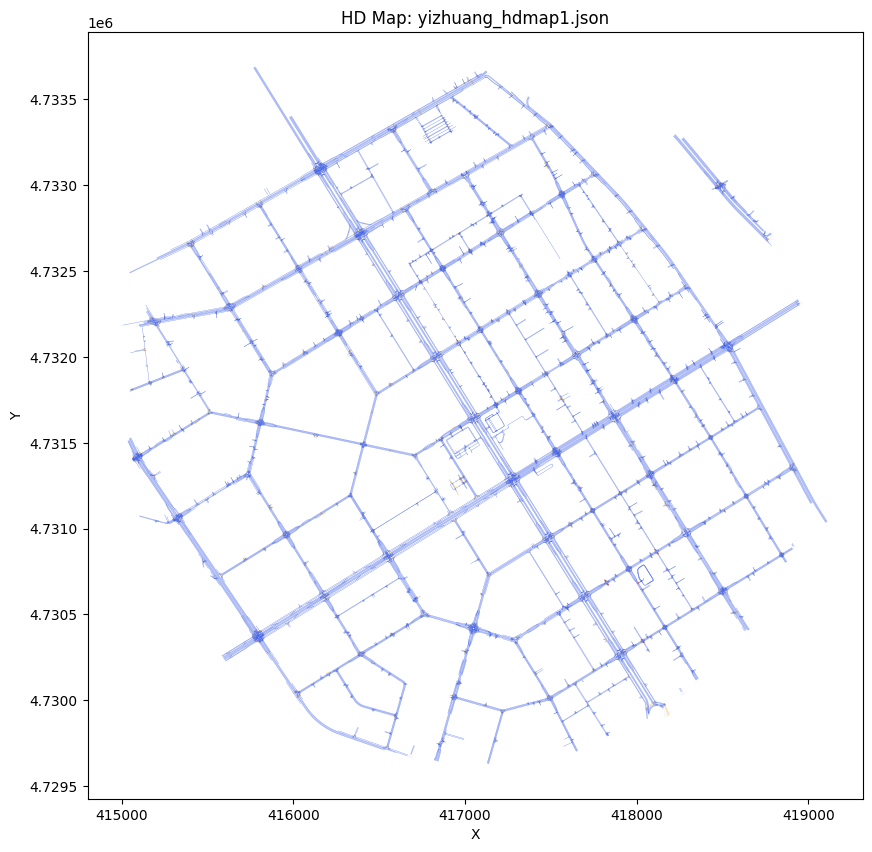

Lanes: 24,827 | Stoplines: 9 | Crosswalks: 955 | Junctions: 969


In [7]:
from pathlib import Path
import json
import ast

try:
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection, PolyCollection
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("matplotlib is required for plotting. Install it in your notebook environment.") from e

maps_dir = Path('../dataset/v2x-traj/maps').resolve()
map_files = sorted(maps_dir.glob('*.json'))
if not map_files:
    raise FileNotFoundError('No map JSON files found in dataset/v2x-traj/maps')

map_file = map_files[0]
print(f'Plotting: {map_file.name}')
map_data = json.loads(map_file.read_text())

def parse_xy(p):
    if isinstance(p, (list, tuple)) and len(p) >= 2:
        return float(p[0]), float(p[1])
    if isinstance(p, str):
        q = ast.literal_eval(p)
        return float(q[0]), float(q[1])
    raise TypeError(f'Unsupported point format: {type(p)}')

def parse_path(points):
    out = []
    for p in points:
        try:
            out.append(parse_xy(p))
        except Exception:
            continue
    return out

# Collect lane centerlines
lane_segments = []
for lane in map_data.get('LANE', {}).values():
    pts = parse_path(lane.get('centerline', []))
    if len(pts) >= 2:
        lane_segments.append(pts)

# Collect stoplines
stopline_segments = []
for stop in map_data.get('STOPLINE', {}).values():
    pts = parse_path(stop.get('centerline', []))
    if len(pts) >= 2:
        stopline_segments.append(pts)

# Collect area polygons
crosswalk_polys = []
for cw in map_data.get('CROSSWALK', {}).values():
    pts = parse_path(cw.get('polygon', []))
    if len(pts) >= 3:
        crosswalk_polys.append(pts)

junction_polys = []
for j in map_data.get('JUNCTION', {}).values():
    pts = parse_path(j.get('polygon', []))
    if len(pts) >= 3:
        junction_polys.append(pts)

fig, ax = plt.subplots(figsize=(10, 10))

if junction_polys:
    ax.add_collection(PolyCollection(junction_polys, facecolors='#f1f3f5', edgecolors='none', alpha=0.5))
if crosswalk_polys:
    ax.add_collection(PolyCollection(crosswalk_polys, facecolors='#fff3bf', edgecolors='#f59f00', linewidths=0.2, alpha=0.6))
if lane_segments:
    ax.add_collection(LineCollection(lane_segments, colors='#4263eb', linewidths=0.25, alpha=0.8))
if stopline_segments:
    ax.add_collection(LineCollection(stopline_segments, colors='#e03131', linewidths=1.0, alpha=0.9))

ax.autoscale()
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'HD Map: {map_file.name}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

print(f'Lanes: {len(lane_segments):,} | Stoplines: {len(stopline_segments):,} | Crosswalks: {len(crosswalk_polys):,} | Junctions: {len(junction_polys):,}')
